In [2]:
import numpy as np
import matplotlib.pyplot as plt  
from scipy.integrate import odeint

# Inputs

In [2]:
P_T = np.array([1,0])
T= np.log(2) #0.7
A=np.array([[0,1],[0,-1]])
B=np.array([1,1])

In [3]:
def u_argmax_hamiltonien(A,B,P_T,T):
    n=10
    t = np.linspace(0,2*T,n)
    t=t[:, np.newaxis, np.newaxis]
    return np.sign(P_T@np.exp(np.kron((T-t),A))@B)
    

In [4]:
def test():
    for i in u_argmax_hamiltonien(A,B,P_T,T):
        print('--check--',i)
#test()

# Valeurs initiales $M_0$

In [5]:
y0 = 1
def calc_X0(T,y0,u):
    if u == 1:
        x0 = y0*np.exp(T)-np.exp(T)-1
    elif u == -1:
        x0 = y0*np.exp(T)+np.exp(T)+3
    else:
        print("valeur u non conforme")
        
    return np.array([x0,y0])

In [6]:
def test():
    for i in calc_X0(T,y0,1):
        print("-----check-----",i)
test()

-----check----- -1.0
-----check----- 1.0


# La trajectoire

## $M_0$

In [7]:
y0 = 1
X_0 = calc_X0(T,y0,1)
print(X_0)

[-1.  1.]


## Controle u

In [ ]:
u = 1 #p(T)=(1,0)

In [8]:
# def Duhamel_X_vectorized(t,X_0):
#     t=t[:, np.newaxis, np.newaxis]
#     X_t = np.exp(np.kron(t,A))@X_0 + (t-0)/2@(np.exp((T)*A)@B) #trapeze n=2
#     return X_t

In [13]:
def Duhamel_X(T,t,X_0):
    #print("----check---", X_0)
    X_t = X_0@np.exp(t*A) + (t-0)/2 * (np.exp(T*A)@B + np.exp((T-t)*A)@B)
    return X_t


In [15]:
def test():
    T=np.log(2)
    a = np.linspace(0,T,10)
    for t in a:
        print(Duhamel_X(T,t,X_0))
#test()

# Représenter les trajectoires:

In [30]:
T = np.log(2)
u = 1
y = [1,2,3,4]
n=10
t = np.linspace(0,T,n)

In [45]:
x_0 = []
X_t = []
for y0 in y:
    #X_0.append(calc_X0(T,y0,u))
    X_0 = calc_X0(T,y0,u)
    x_0.append(X_0[0])
    for i in t:
        X_t.append(Duhamel_X(T,i,X_0))
X_t=np.array(X_t).reshape(len(y),n,2)

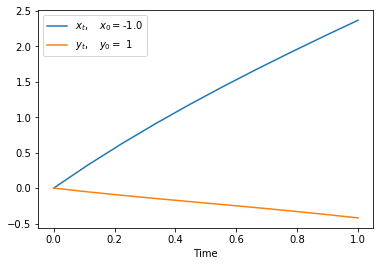

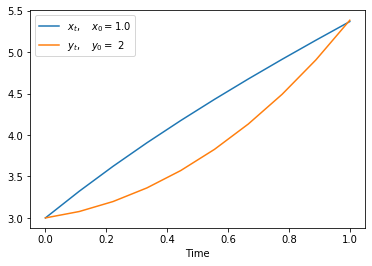

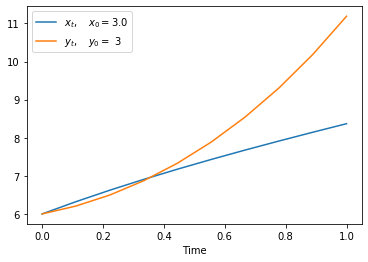

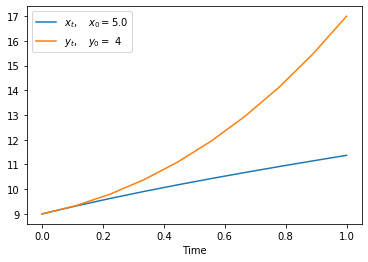

In [46]:
t = np.linspace(0,1,10)
for i,j in enumerate(y):
    plt.figure(1)
    plt.plot(t,X_t[i,:,0],label=r'$x_t, \quad x_0 = $' +str(x_0[i]))
    plt.plot(t,X_t[i,:,1],label=r'$y_t, \quad y_0 = $ '+str(j))
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.show()

# Trajectoires avec GEKKO

In [3]:
from gekko import GEKKO
m = GEKKO()

Final Time (trajectoire -1):  0.9857158334
Final Time (trajectoire -0.5):  0.76446323441
Final Time (trajectoire -0.1):  0.40546442324
Final Time (trajectoire 0.4):  0.70350013648
Final Time (trajectoire 0.7):  0.86511746427
Final Time (trajectoire 1):  0.9857158334


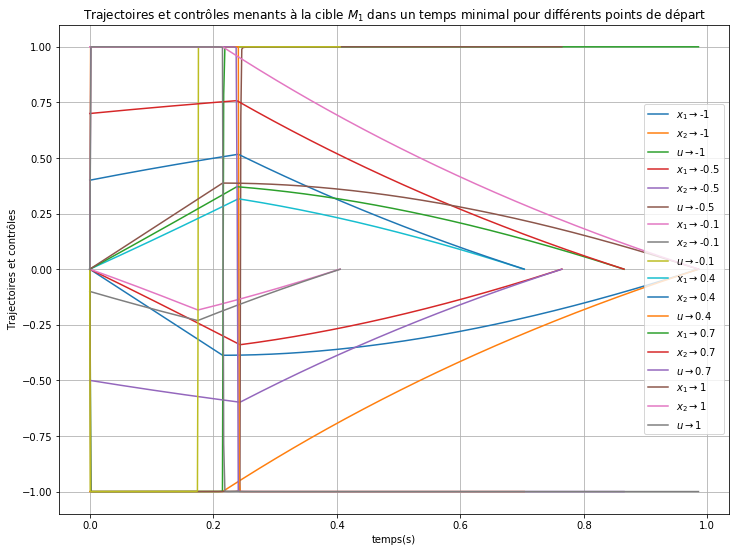

In [34]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set(xlabel='temps(s)', ylabel='Trajectoires et contrôles', title='Trajectoires et contrôles menants à la cible $M_1$ dans un temps minimal pour différents points de départ')
for i in [-1,-0.5,-0.1,0.4,0.7,1]:
    m = GEKKO() # initialize GEKKO
    nt = 501
    penalty=1e6
    penalty_t = 1
    eps=0.0
    m.time = np.linspace(0.1,1,nt)#changement de variable [0,T]->[0,1]

    # Variables
    x1 = m.Var(value=0)
    x2 = m.Var(value=i)

    p = np.zeros(nt) # final time = 1
    p[-1] = 1.0
    final = m.Param(value=p)
    # optimize final time
    tf = m.FV(value=2.0,lb=0.1,ub=20.0)
    tf.STATUS = 1
    # control changes every time period
    u = m.MV(value=0,lb=-1,ub=1)
    u.STATUS = 1
    m.Equation(x1.dt()==tf*(x2+u)) #0,T]->[0,1]
    m.Equation(x2.dt()==tf*(-x2+u)) #0,T]->[0,1]

    m.Obj(penalty_t*tf+penalty*(x1*final+eps)**2+penalty*(x2*final+1)**2+penalty*(x2*final-1)**2)
    m.options.IMODE = 6
    m.solve(disp=False)
    print('Final Time (trajectoire '+str(i)+'):  ' + str(tf.value[0]))
    tm = np.linspace(0,tf.value[0],nt)
  
    ax.plot(tm,x1.value,label=r'$x_1 \rightarrow $'+ str(i))
    ax.plot(tm,x2.value,label=r'$x_2 \rightarrow $'+ str(i))
    ax.plot(tm,u.value,label=r'$u \rightarrow $'+ str(i))
    ax.legend(loc='best')
    ax.grid(True)
fig.savefig('trajectoires')